In [57]:
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf

import sys
import os 
import glob
import shutil
import random
import re

import time
import datetime

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix

from tools import plot_sample_images, split_folder_to_train_test_valid, dir_nohidden

In [58]:

DIRECTORY = "../data/cell_images"
train_dir = os.path.join(DIRECTORY, 'train')
test_dir = os.path.join(DIRECTORY, 'test')
valid_dir = os.path.join(DIRECTORY, 'validation')
#plot_sample_images(DIRECTORY)


In [59]:
# Generates dataset from images files in a directory to make sure all files are fetched

dataset= image_dataset_from_directory(
    DIRECTORY,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)


Found 55116 files belonging to 5 classes.


In [60]:
def plot_sample_images(directory, num_samples=5):
    classes = ['Uninfected', 'Parasitized']
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(15, 10))

    for i, cls in enumerate(classes):
        class_dir = os.path.join(directory, cls)
        class_images = os.listdir(class_dir)[:num_samples]
        for j, image_name in enumerate(class_images):
            image_path = os.path.join(class_dir, image_name)
            img = load_img(image_path, target_size=(224, 224))
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(cls)
    plt.show()

# Set your dataset path
# Plot sample images from the training directory


In [61]:

def split_folder_to_train_test_valid(data_directory):
    """
    Splits data from the original directory into train, test, and validation directories for each class.
    
    Args:
        data_directory (str): Path to the original data directory containing subdirectories for each class.
    """
    train_dir = os.path.join(data_directory, 'train')
    test_dir = os.path.join(data_directory, 'test')
    validation_dir = os.path.join(data_directory, 'validation')

    # Get a list of class subdirectories in the original data directory
    class_subdirectories = [d for d in os.listdir(data_directory) if os.path.isdir(os.path.join(data_directory, d))]

    for class_subdir in class_subdirectories: # for 'Class' in ['Class1', 'Class2']
        class_path = os.path.join(data_directory, class_subdir) # ../data/cell_images/Parasitized and ../data/cell_images/Uninfected
        class_images = [img for img in os.listdir(class_path)] # ['C13NThinF_IMG_20150614_131318_cell_179.png'... all images for each class

        train_images, test_validation_images = train_test_split(class_images, test_size=0.3, random_state=42)
        test_images, validation_images = train_test_split(test_validation_images, test_size=0.5, random_state=42)

        print(f'Total images for class {class_subdir}: ', len(class_images)) # 13780 (all images for class_subdir) or 100%
        print(f'Total train images: {len(train_images)} or {(len(train_images)/len(class_images))*100}% ') # 9646 (70% of all images from class_images)
        print(f'Total test images: {len(test_images)} or {len(test_images)/len(class_images)*100}% ') # 2067 class 1 15%
        print(f'Total validation images: {len(validation_images)} or {len(validation_images)/len(class_images)*100}% ')
        print('\n')


        # Create Class 1 and Class 2 subdirectories inside new folders
        train_class_dir = os.path.join(train_dir, class_subdir)
        os.makedirs(train_class_dir, exist_ok=True)

        test_class_dir = os.path.join(test_dir, class_subdir)
        os.makedirs(test_class_dir, exist_ok=True)

        validation_class_dir = os.path.join(validation_dir, class_subdir)
        os.makedirs(validation_class_dir, exist_ok=True)

        # Move images from each class folder to new subdirectories
        for img in train_images:
            src_path =os.path.join(class_path, img)
            dst_path =os.path.join(train_class_dir,img)
            shutil.copy(src_path, dst_path)


        for img in test_images:
            src_path =os.path.join(class_path, img)
            dst_path =os.path.join(test_class_dir,img)
            shutil.copy(src_path, dst_path)


        for img in validation_images:
            src_path =os.path.join(class_path, img)
            dst_path =os.path.join(validation_class_dir,img)
            shutil.copy(src_path, dst_path)

    folder_dir = []
    for x in ['train', 'test', 'validation']: folder_dir.append((os.path.join('../data/cell_images/', x)))

    for i in folder_dir:
        for name in os.listdir(i):
            print(i, name ,len(os.listdir(os.path.join(i,name))))
        # Print new sizes for each new folder

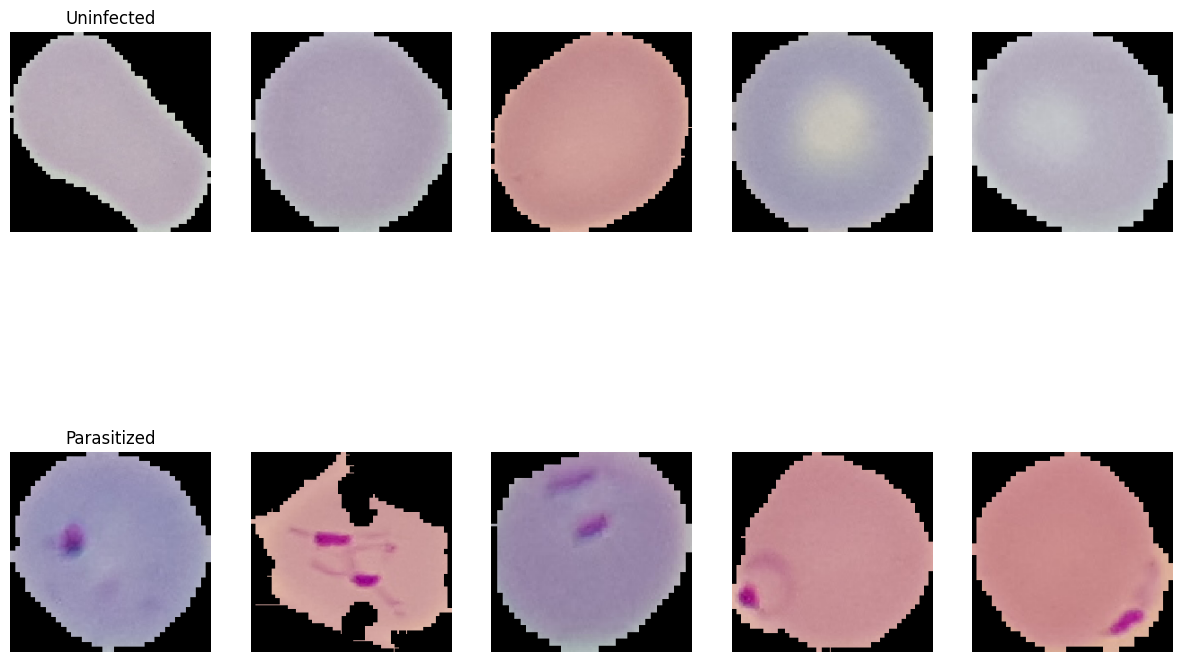

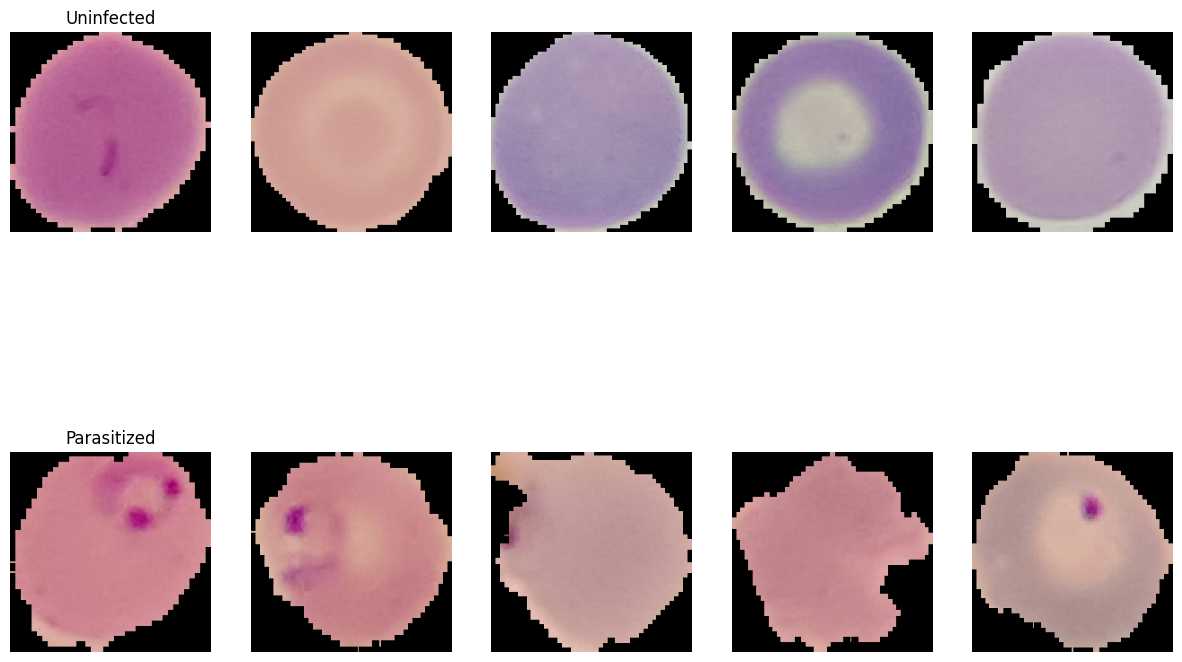

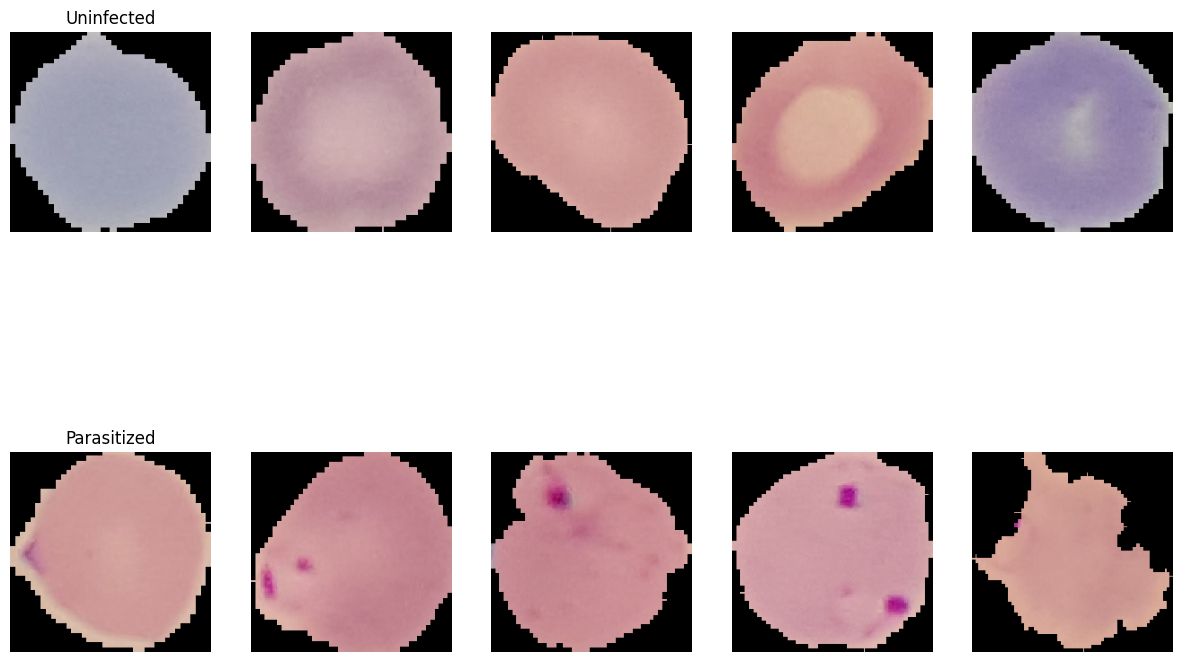

In [62]:
# Split the data into train, validation and test folders from original folder with 2 classes each

def dir_nohidden(path):
    dir = []
    for f in os.listdir(path):
         if not f.startswith('.'):
            dir.append(f)
    return dir


# Make sure we're not splitting data more than once in case we re-run the code
if len(dir_nohidden(DIRECTORY)) <= 2: 
    split_folder_to_train_test_valid(DIRECTORY)

#See samples for each class for each folder
else:
    for i in ['train', 'test', 'validation']:
        plot_sample_images(os.path.join(DIRECTORY, i))


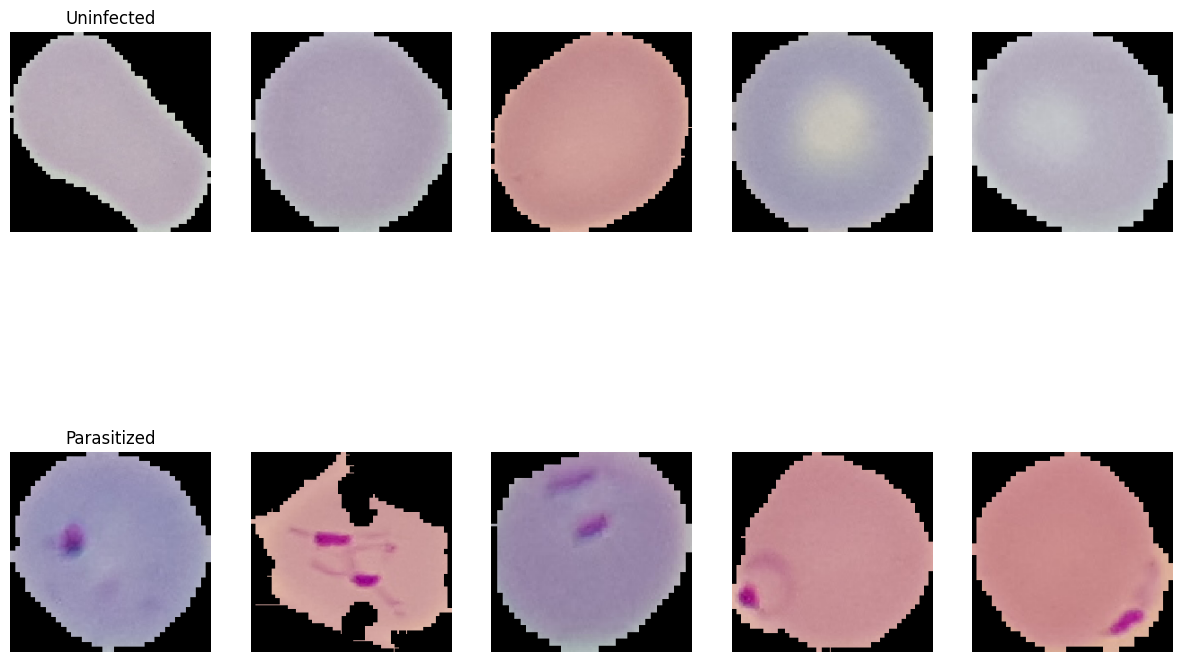

Found 19290 files belonging to 2 classes.
{'featurewise_center': False, 'samplewise_center': False, 'featurewise_std_normalization': False, 'samplewise_std_normalization': False, 'zca_whitening': False, 'zca_epsilon': 1e-06, 'rotation_range': 15, 'width_shift_range': 0.05, 'height_shift_range': 0.05, 'shear_range': 0.0, 'zoom_range': [0.8, 1.2], 'channel_shift_range': 0.0, 'fill_mode': 'nearest', 'cval': 0.0, 'horizontal_flip': False, 'vertical_flip': False, 'rescale': 0.00392156862745098, 'preprocessing_function': None, 'dtype': 'float32', 'interpolation_order': 1, 'data_format': 'channels_last', 'channel_axis': 3, 'row_axis': 1, 'col_axis': 2, '_validation_split': 0.0, 'mean': None, 'std': None, 'zca_whitening_matrix': None, 'brightness_range': None}
Found 19290 images belonging to 2 classes.


In [63]:
# Visualazing Images and Corresponding labels from the dataset

original_data_dir = '../data/cell_images'
train_dir = '../data/cell_images/train'
test_dir = '../data/cell_images/test'
validation_dir = '../data/cell_images/validation'

# Plot sample images 
plot_sample_images(train_dir)

# Image data loading
# Generates dataset from images files in a directory

training_dataset= image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)
# Found 27558 files belonging to 2 classes.
'''
yields batches of images from the subdirectories Parasitized and Uninfected, 
together with labels 0 and 1 (0 corresponding to Parasitized and 1 corresponding to Uninfected).
'''


# Data Augmentation using Keras library. 


training_data_generator = ImageDataGenerator(
    rescale=1.0/255, 
    zoom_range=0.2, 
    rotation_range=15, 
    width_shift_range=0.05, 
    height_shift_range=0.05)


'''
Modify training_data_generator so that it will also automatically perform pixel normalization. 
Rescale keyword argument equal to 1.0/255.

Set zoom_range to be 0.2. This will randomly increase or decrease the size of the image by up to 20%.

Set rotation_range to be 15. This randomly rotates the image between [-15,15] degrees.

Set width_shift_range equal to 0.05. This shift the image along its width by up to +/- 5%

Set height_shift_range to be 0.05. This shifts the image along its height by up to +/- 5%
'''

print(training_data_generator.__dict__)

'''
data/cell_images is the folder containing cell images organized in 2 folders
Parasitized: RBC infected with Plasmodium
Uninfected: RBC not infected
flow_from_directory will automatically label the images according to their subfolder
'''

CLASS_MODE="categorical"
'''
Categorical loss function will be used, which will exepct labels to be in a a OHE format. 
[0,1] for Infected and [1,0] for not infected'''

COLOR_MODE="rgb"

TARGET_SIZE = (64,64)

BATCH_SIZE = 32


# Creates a DirectoryIterator object using the above parameters: 

training_iterator = training_data_generator.flow_from_directory(
    train_dir,
    class_mode=CLASS_MODE,
    color_mode=COLOR_MODE, 
    target_size=TARGET_SIZE, 
    batch_size=BATCH_SIZE
)

In [64]:
sample_batch_input, sample_batch_labels = training_iterator.next()

print(sample_batch_input.shape,sample_batch_labels.shape)

(32, 64, 64, 3) (32, 2)


In [65]:
class_mapping = training_iterator.class_indices
print(class_mapping)

{'Parasitized': 0, 'Uninfected': 1}


Make sure everything was moved in the correct proportions: 

In [66]:
folder_dir = []
for x in ['train', 'test', 'validation']: folder_dir.append((os.path.join('../data/cell_images/', x)))

for i in folder_dir:
    for name in os.listdir(i):
        print(i, name ,len(os.listdir(os.path.join(i,name))))

../data/cell_images/train Parasitized 9646
../data/cell_images/train Uninfected 9646
../data/cell_images/test Parasitized 2067
../data/cell_images/test Uninfected 2067
../data/cell_images/validation Parasitized 2067
../data/cell_images/validation Uninfected 2067


In [67]:

test_data_generator = ImageDataGenerator()

validation_data_generator = ImageDataGenerator()

# Data Augmentation using Keras library. 
training_data_generator = ImageDataGenerator(
    rescale=1.0/255, 
    zoom_range=0.2, 
    rotation_range=15, 
    width_shift_range=0.05, 
    height_shift_range=0.05)


Modify training_data_generator so that it will also automatically perform pixel normalization. 
Rescale keyword argument equal to 1.0/255.

Set zoom_range to be 0.2. This will randomly increase or decrease the size of the image by up to 20%.

Set rotation_range to be 15. This randomly rotates the image between [-15,15] degrees.

Set width_shift_range equal to 0.05. This shift the image along its width by up to +/- 5%

Set height_shift_range to be 0.05. This shifts the image along its height by up to +/- 5%

In [68]:
training_data_generator.__dict__

{'featurewise_center': False,
 'samplewise_center': False,
 'featurewise_std_normalization': False,
 'samplewise_std_normalization': False,
 'zca_whitening': False,
 'zca_epsilon': 1e-06,
 'rotation_range': 15,
 'width_shift_range': 0.05,
 'height_shift_range': 0.05,
 'shear_range': 0.0,
 'zoom_range': [0.8, 1.2],
 'channel_shift_range': 0.0,
 'fill_mode': 'nearest',
 'cval': 0.0,
 'horizontal_flip': False,
 'vertical_flip': False,
 'rescale': 0.00392156862745098,
 'preprocessing_function': None,
 'dtype': 'float32',
 'interpolation_order': 1,
 'data_format': 'channels_last',
 'channel_axis': 3,
 'row_axis': 1,
 'col_axis': 2,
 '_validation_split': 0.0,
 'mean': None,
 'std': None,
 'zca_whitening_matrix': None,
 'brightness_range': None}

In [69]:
# Creates a DirectoryIterator object using the above parameters: 
print('TRAINING FOLDER')
training_iterator = training_data_generator.flow_from_directory(
    train_dir,
    class_mode=CLASS_MODE,
    color_mode=COLOR_MODE, 
    target_size=TARGET_SIZE, 
    batch_size=BATCH_SIZE
)# subset='training'

TRAINING FOLDER
Found 19290 images belonging to 2 classes.


`next()` is used to fetch the next batch of data from the iterator. 
Returns a tuple containing the input batch (images) and corresponding label batch. 

In [70]:
sample_batch_input, sample_batch_labels = training_iterator.next()


Each folder now contains cell images organized in 2 folders
Parasitized: RBC infected with Plasmodium
Uninfected: RBC not infected
flow_from_directory will automatically label the images according to their subfolder

In [72]:
print("\nLoading validation data...")


print('VALIDATION FOLDER: ')
validation_iterator = validation_data_generator.flow_from_directory(
    valid_dir,
    class_mode=CLASS_MODE,
    color_mode=COLOR_MODE, 
    target_size=TARGET_SIZE, 
    batch_size=BATCH_SIZE
) # subset='validation


Loading validation data...
VALIDATION FOLDER: 
Found 4134 images belonging to 2 classes.


In [73]:
print('TEST FOLDER: ')
test_iterator = test_data_generator.flow_from_directory(
    test_dir,
    class_mode=CLASS_MODE, 
    color_mode=COLOR_MODE,
    target_size=TARGET_SIZE, 
    batch_size=BATCH_SIZE
) # subset='test


print(sample_batch_input.shape,sample_batch_labels.shape)
# (32, 256, 256, 3) (32, 2)

TEST FOLDER: 
Found 4134 images belonging to 2 classes.
(32, 64, 64, 3) (32, 2)


In [75]:
print("\nBuilding model...")


Building model...


In [76]:

def design_model():
    '''
    Model as defined by Sumit Kumar et al. 
    Ref: https://arxiv.org/pdf/2303.03397.pdf
    '''
    input_shape = (64, 64, 3)
    
    model = Sequential()
    
    model.add(tf.keras.Input(shape=input_shape))
              
    # First convolution layer
    model.add(Conv2D(
        32, (3, 3), 
        strides=(1, 1), 
        padding='valid', 
        activation='relu', 
        input_shape=input_shape))
    
    # Max pooling layer
    model.add(MaxPooling2D(
        pool_size=(2, 2), 
        strides=(2,2)))
    
    # Batch normalization
    model.add(BatchNormalization())
    
    # Dropout layer
    model.add(Dropout(0.2))
    
    # Second convolution layer
    model.add(Conv2D(
        32, (3, 3), 
        strides=(1, 1), 
        padding='valid', 
        activation='relu'))
    
    # Max pooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Batch normalization
    model.add(BatchNormalization())
    
    # Dropout layer
    model.add(Dropout(0.2))
    
    # Flatten layer to prepare for fully connected layers
    model.add(Flatten())

    # Feed-Forward Network
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Output Layer
    model.add(Dense(2,activation="softmax")) # 2 Classes


    # compile model with Adam optimizer
    # loss function is categorical crossentropy
    # metrics are categorical accuracy and AUC
    print("\nCompiling model...")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=.001),
        loss=tf.keras.losses.CategoricalCrossentropy(), 
        metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC()],)
    
    # summarize model
    model.summary()
    return model
    
model = design_model()
# model with input shape (64, 64, 3)



Compiling model...
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_16 (Ba  (None, 31, 31, 32)        128       
 tchNormalization)                                               
                                                                 
 dropout_16 (Dropout)        (None, 31, 31, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None

In [77]:
model = design_model()
# model with input shape (64, 64, 3)


Compiling model...
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 31, 31, 32)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_20 (Ba  (None, 31, 31, 32)        128       
 tchNormalization)                                               
                                                                 
 dropout_20 (Dropout)        (None, 31, 31, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_11 (MaxPooli  (None

In [78]:

# early stopping implementation
es = EarlyStopping(monitor='val_auc', mode='min', verbose=1, patience=20)

print("\nTraining model...")
history= model.fit(
    training_iterator, 
    steps_per_epoch=training_iterator.samples/BATCH_SIZE, epochs=50, 
    validation_data=validation_iterator,
    validation_steps=validation_iterator.samples/BATCH_SIZE, 
    callbacks=[es]
)


Training model...
Epoch 1/50
602/602 [==============================] - 105s 170ms/step - loss: 0.6054 - categorical_accuracy: 0.7074 - auc_5: 0.7747 - val_loss: 228.9044 - val_categorical_accuracy: 0.5070 - val_auc_5: 0.5070
Epoch 2/50
602/602 [==============================] - 87s 144ms/step - loss: 0.2765 - categorical_accuracy: 0.8948 - auc_5: 0.9527 - val_loss: 206.2142 - val_categorical_accuracy: 0.5431 - val_auc_5: 0.5434
Epoch 3/50
602/602 [==============================] - 84s 139ms/step - loss: 0.2226 - categorical_accuracy: 0.9207 - auc_5: 0.9678 - val_loss: 2060.5315 - val_categorical_accuracy: 0.5000 - val_auc_5: 0.5000
Epoch 4/50
602/602 [==============================] - 91s 152ms/step - loss: 0.1955 - categorical_accuracy: 0.9318 - auc_5: 0.9745 - val_loss: 2251.5781 - val_categorical_accuracy: 0.5000 - val_auc_5: 0.5000
Epoch 5/50
602/602 [==============================] - 86s 143ms/step - loss: 0.1882 - categorical_accuracy: 0.9359 - auc_5: 0.9757 - val_loss: 1568.81

In [79]:
# Evaluate the model on the test data
test_metrics = model.evaluate(test_iterator, steps=test_iterator.samples / BATCH_SIZE)

129/129 [==============================] - 8s 59ms/step - loss: 72830.8984 - categorical_accuracy: 0.5000 - auc_5: 0.5000


Test Loss: 72830.8984375
Test Accuracy: 0.5


KeyError: 'auc'

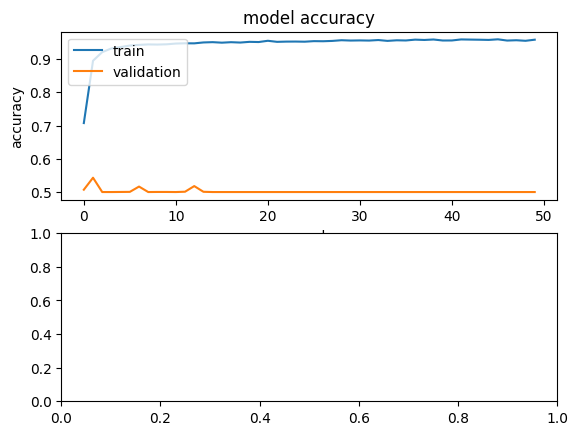

In [80]:
# Print the test metrics
print("Test Loss:", test_metrics[0])
print("Test Accuracy:", test_metrics[1])


# plotting categorical and validation accuracy over epochs
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(history.history['categorical_accuracy'])
ax1.plot(history.history['val_categorical_accuracy'])
ax1.set_title('model accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.legend(['train', 'validation'], loc='upper left')

# plotting auc and validation auc over epochs
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(history.history['auc'])
ax2.plot(history.history['val_auc'])
ax2.set_title('model auc')
ax2.set_xlabel('epoch')
ax2.set_ylabel('auc')
ax2.legend(['train', 'validation'], loc='upper left')
plt.show()




In [81]:

test_steps_per_epoch = np.math.ceil(validation_iterator.samples / validation_iterator.batch_size)
predictions = model.predict(validation_iterator, steps=test_steps_per_epoch)
test_steps_per_epoch = np.math.ceil(validation_iterator.samples / validation_iterator.batch_size)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_iterator.classes
class_labels = list(validation_iterator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   


cm=confusion_matrix(true_classes,predicted_classes)
print(cm)

130/130 [==============================] - 6s 46ms/step
              precision    recall  f1-score   support

 Parasitized       0.00      0.00      0.00      2067
  Uninfected       0.50      1.00      0.67      2067

    accuracy                           0.50      4134
   macro avg       0.25      0.50      0.33      4134
weighted avg       0.25      0.50      0.33      4134

[[   0 2067]
 [   0 2067]]


/Users/alejandroflores/VS_CODE/CNN-Malaria-Detection/malaria-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alejandroflores/VS_CODE/CNN-Malaria-Detection/malaria-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alejandroflores/VS_CODE/CNN-Malaria-Detection/malaria-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi